**[YOU CAN VIEW THIS NOTEBOOK INCLUDING THE INTERACTIVE PLOTS USING THIS LINK](https://nbviewer.jupyter.org/github/DCMLab/schubert_dances/blob/master/schubert_project.ipynb)**

<font size=15>Table of Contents</font>
- [about this project](#about-this-project)
  * [abstract](#abstract)
  * [research questions and hypotheses](#research-questions-and-hypotheses)
  * [dataset](#dataset)
- [configuration](#configuration)
- [helper functions](#helper-functions)
- [loading the data](#loading-the-data)
  * [computing or loading the dataframe representation of the music](#computing-or-loading-the-dataframe-representation-of-the-music)
- [basic statistics](#basic-statistics)
  * [pieces per dance type](#pieces-per-dance-type)
  * [constellations of sections](#constellations-of-sections)
  * [section lengths](#section-lengths)
  * [distribution of key signatures](#distribution-of-key-signatures)
  * [number and distribution of notes](#number-and-distribution-of-notes)
  * [average note duration](#average-note-duration)
    + [transposed to c major resp. a minor](#transposed-to-c-major-resp-a-minor)
  * [key signatures](#key-signatures)
  * [entropy of the pitch class distribution](#entropy-of-the-pitch-class-distribution)
  * [provisional mode classification](#provisional-mode-classification)
    + [key profiles](#key-profiles)
  * [event density](#event-density)
  * [interval statistics for top pseudo-voice](#interval-statistics-for-top-pseudo-voice)
    + [distribution by dance type](#distribution-by-dance-type)
- [roadmap for the project](#roadmap-for-the-project)
  * [repeating pattern detection with autocorrelation (sébastien)](#repeating-pattern-detection-with-autocorrelation--s-bastien-)
  * [harmony inference (johannes h.) and detection of musical schemata](#harmony-inference--johannes-h--and-detection-of-musical-schemata)
  * [supervised dance classification (gabriele, johannes r.)](#supervised-dance-classification--gabriele--johannes-r-)
- [Internal: How plotting works](#internal--how-plotting-works)

<small><i><a href='http://ecotrust-canada.github.io/markdown-toc/'>Table of contents generated with markdown-toc</a></i></small>


# about this project
## abstract
>Everybody has an emotional access to music, which in turn transports listeners into specific moods, atmospheres and settings. This intuitive understanding of musical pieces is grounded in structural elements such as melodic motives and rhythms, with their variations or repetitions.<p> 
Our project aims at gaining an objective insight into how these patterns engender different shades of musical engagement. Specifically, we will investigate the structure and composition of Franz Schubert's "dances", a large set of 400 piano pieces classified in seven different types according to their times’ conventions. The conventionality of these short and catchy pieces makes them an ideal testing ground for computer-assisted analysis, but also makes them highly representative of the taste of early-nineteenth-century listeners. With our statistical investigation we hope to open a window onto this past: what did listeners expect of appealing dance-like music, and did different dance types correspond to different musical features or just to different social perspectives on the same musical features?

**Update** After the first analysis of our data set we are confident that we have the means to give a tentative answer to the question whether the different dance types display essential differences in their musical features or whether the difference lies mainly in their denomination. In the section [Key signatures](#key-signatures) we show that all dances are either in double (2/4) or triple meter (3/4) which are, of course, musically distinct on first hearing. Therefore the aforementioned question diversifies into classification between dance types in double meter and between those in triple meter respectively. Also, we now have eight instead of seven different dance types because we decided to evaluate **Trio** sections as separate types for two reasons. On the one hand, it can be expected that Trios differ in their musical parameters. On the other hand, they often introduce new motives, rhythms and key signatures and therefore can be considered as separate pieces.
    
## research questions and hypotheses

* What recurring patterns and regularities make Schubert's dances so intuitively appealing and easy to grasp? Possible levels of investigation:
  * rhythmic patterns
  * melodic patterns
  * harmonic makeup
  * formal level
* Are the different dance types musically distinguishable? Which features will a classifier use to distinguish the different dance types? Hypothetically, these features will include:
  * meter
  * melodic motives and shapes
  * musical form
  * harmonic progressions
  * rhythmic markup
  * musical texture
  * relation between the two hands

## dataset
The dataset consists of the scores, in MuseScore 3 XML format, of all 394 dances written for piano by Franz Schubert (1797-1828).

The dances include short pieces in triple meter, such as:
* Waltzs
* Minuets
* Ländlers
* Deutsche Tänze
* Cotillions

And short pieces in binary meter, such as:
* Ecossaises
* Galops

**Distribution:**

|     type       |count|
|----------------|----:|
|walzer          |  132|
|ländler         |   80|
|ecossaise       |   78|
|deutscher       |   71|
|trio            |   35|
|menuett         |   29|
|trio I          |    5|
|trio II         |    5|
|galopp          |    2|
|cotillon        |    1|
|alternative_trio|    1|

Most of this dataset was crawled from the web and cleaned by ourselves,
and the rest has been directly typesetted in a group effort.

The dataset is labelled at the piece level, so we have the name of the dance types for each piece.
But no label exists (yet) at the section or chord levels.

In [7]:
%load_ext autoreload
%autoreload 2
# import os
# os.chdir(/path/to/git_folder)
from tools.ms3 import *
import itertools
import scipy as sp
from plotly.offline import iplot
import cufflinks as cf # for creating plots from pandas on the fly
import plotly.io as IO
cf.go_offline()
cf.set_config_file(theme='ggplot') #{'solar', 'pearl', 'white', 'ggplot'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# configuration 

In [8]:
compute_all = False                              # Sets all 'compute_anew' flags to True
logging.getLogger().setLevel(logging.WARNING)    # logging level
data ='data'                                     # data folders
data_ms3 = os.path.join(data,'MuseScore_3')
data_tsv = os.path.join(data,'tsv')
note_features = None                             # TODO: Pass selected features as kwargs to get_notes()
#plt.rcParams['figure.figsize'] = [15,10]        # Change the plotsize for matplotlib in the entire notebook
std_plotsize = (1100, 500)                       # Standard plotsize (in px) for storing plotly images to disk 
                                                 # (the ones in the notebook adapt to windows size)

# helper functions

In [9]:
def plot(df, fname='test.png', kind='scatter', size=std_plotsize,  **kwargs):
    fig = df.iplot(asFigure=True,kind=kind, **kwargs)
    #fig.update(layout={})
    w, h = size[0], size[1]
    IO.write_image(fig, fname, width=w, height=h)
    iplot(fig)

In [10]:
def bag_of_notes(df, tpc='tpc'):
    """Input: DataFrame including the columns ['tpc', 'duration']"""
    tpcs = df.tpc
    occurring = np.sort(tpcs.unique())
    bag = pd.DataFrame(index=occurring, columns=['count_a', 'count_n', 'duration_a', 'duration_n'])
    GB = df.groupby('tpc')
    bag.count_a = GB.size()
    bag.count_n = bag.count_a / bag.count_a.sum()
    bag.duration_a = GB['duration'].sum().astype(float)
    bag.duration_n = (bag.duration_a / bag.duration_a.sum()).astype(float)
    if tpc != 'tpc':
        names = tpc.split('+')
        note_names = []
        for n in names:
            if n == 'tpc':
                note_names.append(occurring)
            elif n == 'name':
                note_names.append(tpc2name(occurring))
            elif n == 'degree':
                note_names.append(tpc2degree(occurring))
            elif n == 'pc':
                note_names.append(tpc2pc(occurring))
            else:
                logging.warning("Parameter tpc can only be {'tpc', 'name', 'degree', 'pc'} or a combination such as 'tpc+pc' or 'name+degree+tpc'.")
        L = len(note_names)
        if L == 0:
            note_names.append(bag.index)
            L = 1
        if L == 1:
            bag.index = note_names[0]
        else:
            bag.index = [f"{t[0]} ({', '.join(str(e) for e in t[1:])})" for t in zip(*note_names)]
    return bag

# loading the data
The dataframe `merged_ids` maps the 435 IDs to the files in the `data_ms3` folder. The different types of trios (trio I, trio II, alternative trio) are all replaced by the term 'trio'.

In [11]:
merged_ids = os.path.join(data_ms3, 'merged_ids.tsv')
files = pd.read_csv(merged_ids, sep='\t', index_col=0)
files.loc[files.dance.str.contains('trio'), 'dance'] = 'trio'
files.head()

,D,no,dance,path
id,,,,
1,41,1,menuett,041/D041menuett01a.mscx
2,41,1,trio,041/D041trio01b.mscx
3,41,2,menuett,041/D041menuett02a.mscx
4,41,2,trio,041/D041trio02b.mscx
5,41,3,menuett,041/D041menuett03a.mscx


**Accessibility**
We check whether all files are accessible.

In [12]:
missing = [file for file in files.path.values if not os.path.isfile(os.path.join(data_ms3, file))]
if missing != []:
    print("These files are missing:\n" + '\n'.join(missing))
else:
    print("All files found.")

All files found.


## computing or loading the dataframe representation of the music
We will be working on the data set in the form of note_lists. These can be newly computed from the scores or loaded from the precomputed TSV.

In [13]:
compute_anew = False

if compute_anew or compute_all:

    parse_score = lambda path: Score(os.path.join(data_ms3,path))
    score_objects = pd.DataFrame(files.path.apply(parse_score)).rename(columns={'path': 'object'})
    note_list = score_objects.groupby('id').apply(lambda df: df.iloc[0,0].get_notes(volta_warning=False))
    note_list.to_csv(os.path.join(data_tsv, 'note_list_complete.tsv'), sep='\t')
    measure_list = score_objects.groupby('id').apply(lambda df: df.iloc[0,0].info)\
                                .astype({'section': int, 
                                         'keysig': int, 
                                         'voices': int, 
                                         'volta': 'Int64', 
                                         'numbering_offset': 'Int64', 
                                         'dont_count': 'Int64'})
    measure_list.to_csv(os.path.join(data_tsv, 'measure_list_complete.tsv'), sep='\t')
    section_order = score_objects.applymap(lambda x: x.section_order).rename(columns = {'path': 'sections'})
    section_order.to_csv(os.path.join(data_tsv, 'section_order_complete.tsv'), sep='\t')
    
else:
    note_list = pd.read_csv(os.path.join(data_tsv, 'note_list_complete.tsv'), sep='\t', index_col=[0,1,2], 
                            dtype={'tied': 'Int64', 
                                   'volta': 'Int64'}, 
                            converters={'onset':frac, 
                                        'duration':frac, 
                                        'nominal_duration':frac, 
                                        'scalar':frac})
    measure_list = pd.read_csv(os.path.join(data_tsv, 'measure_list_complete.tsv'), sep='\t', index_col=[0,1], 
                               dtype={'volta': 'Int64', 
                                      'numbering_offset': 'Int64', 
                                      'dont_count': 'Int64'}, 
                               converters={'timesig': frac, 
                                           'duration': frac, 
                                           'act_dur': frac, 
                                           'offset': frac, 
                                           'next': lambda l: [int(mc) for mc in l.strip('[]').split(', ') if mc != '']})
    section_order = pd.read_csv(os.path.join(data_tsv, 'section_order_complete.tsv'), sep='\t', index_col = [0])\
                      .rename(columns={'object': 'sections'})
## converters={'object': lambda l: [int(s) for s in l.strip('[]').split(', ')]}
                                
    note_list.head()

# basic statistics

## pieces per dance type

In [14]:
dance_types = files.dance.value_counts()
print(f"The corpus contains {len(files.index)} pieces. The different types are distributed as follows:{NL}{dance_types}")
dance_types.iplot('bar')

The corpus contains 435 pieces. The different types are distributed as follows:
walzer       132
ländler       78
ecossaise     74
deutscher     71
trio          48
menuett       29
galopp         2
cotillon       1
Name: dance, dtype: int64


## constellations of sections

In [15]:
print('The vast majority of the dances is notated in two repeated sections, AABB.')
section_order.sections.value_counts().iplot('bar')

The vast majority of the dances is notated in two repeated sections, AABB.


## section lengths

In [16]:
print('Most sections are normatively 8 measures long, but there are also several 16 measure-long sections: it could be hypothesised that these sections are internally binary.')
measure_list.groupby(['id', 'section']).size().value_counts().iplot('bar', xTitle='Section length (in bars)', yTitle='Count')

Most sections are normatively 8 measures long, but there are also several 16 measure-long sections: it could be hypothesised that these sections are internally binary.


## distribution of key signatures

In [17]:
measure_list.keysig.sort_values().apply(tpc2key).iplot('hist', xTitle='Key', yTitle = 'Fraction of bars with given key signature', histnorm = 'probability')

## number and distribution of notes

In [18]:
print(f"The data set has {len(note_list.index)} note events in total, and {len(note_list.index[note_list.gracenote.isna()])} notes without grace notes.")

The data set has 101810 note events in total, and 101231 notes without grace notes.


In [19]:
tpc_distribution = bag_of_notes(note_list, 'name')

In [20]:
tpc_distribution[['count_a', 'duration_a']].iplot('bar', xTitle='Tonal Pitch Class', yTitle='Absolute note counts<br>Durations (in quarter beats)')

In [21]:
tpc_distribution[['count_n', 'duration_n']].iplot('bar', xTitle='Tonal Pitch Class', yTitle='Normalized note counts & durations')

## average note duration

The duration and count of tonal pitch-classes are analogously distributed over the corpus. This implies that the average duration of each note is roughly independent of its tonal pitch class.

In [22]:
average_duration = pd.DataFrame(tpc_distribution['duration_a']/tpc_distribution['count_a'], columns = ['Average duration'])

average_duration.iplot('bar')

The common average duration is close to a quarter note, which is also the common tactus of all the dances (that are only written in 3/4 or 2/4 meter).

### transposed to c major resp. a minor

In [23]:
note_list_transposed = note_list.merge(measure_list['keysig'], on=['id', 'mc'], right_index=True)   # Add a column with the corresponding key signature for every note
note_list_transposed.tpc -= note_list_transposed.keysig                                             # subtract key signature from tonal pitch class (=transposition to C)
midi_transposition = tpc2pc(note_list_transposed.keysig)\
                     .apply(lambda x: x if x <= 6 else x % -12)                                     # convert key signature to pitch class and decide whether MIDIs are shifted downwards (if <= 6) or upwards
up_or_down = (midi_transposition == 6)                                                              # if the shift is 6, the direction of shift depends on the key signature:
midi_transposition.loc[up_or_down] = note_list_transposed[up_or_down].keysig\
                                     .apply(lambda x: 6 if x > 0 else -6)                           # If the key signature is F#, shift downwards, if it's Gb, shift upwards
note_list_transposed.midi -= midi_transposition                                                     # transpose MIDIs
transposed_distribution = bag_of_notes(note_list_transposed, 'degree+name')

In [24]:
transposed_distribution[['count_a', 'duration_a']].iplot('bar', xTitle='Tonal Pitch Class', yTitle='Absolute note counts<br>Durations (in quarter beats)')

In [25]:
transposed_distribution[['count_n', 'duration_n']].iplot('bar', xTitle='Tonal Pitch Class', yTitle='Normalized note counts & durations')

**Comment** After shifting all major pieces to C and all minor pieces to A, the distribution reveals two things:
* As is typical for music where most of the chords are rooted on `I` (*tonic* chords) or on `V` (*dominant* chords), the note of the `V`th degree is even more frequent than the root of the key (`I`) because the note `V` appears in the chord on `I` **and** in the chord on `V`.
* Apparently, the majority of the dances stands in major keys because otherwise we would expect higher ratios for `VI` (the minor root) and `#V` (its leading tone).
* A bimodal distribution can still be recognised, with a peak centered on the dominant of major keys and another one on the dominant of minor keys (`III`). However, the occurrence of the scale degree `III` is boosted by being a relevant component of both the major (mediant) and minor (dominant) relative keys. 

## key signatures

In [26]:
float_timesig = measure_list
float_timesig['timesig'] = measure_list.timesig.apply(str)
float_timesig.groupby('timesig').apply(lambda x: len(x)/len(measure_list)).iplot('bar', xTitle = 'Time signature', yTitle = 'Frequency')

## entropy of the pitch class distribution

For each dance, we compute the entropy of the distribution of tonal pitch classes, normalised to the alphabet of all 35 tpcs up to 2 accidentals.

In [27]:
note_list_by_dance = note_list.groupby('id').apply(lambda x: bag_of_notes(x, 'tpc'))
entropies = note_list_by_dance.groupby('id').apply(lambda x: sp.stats.entropy(x.count_a)/np.log(35))

entropies.iplot('hist', bins = 50, xTitle = 'Normalised entropy')



The entropy distribution seems to be independent of the key signature, with no significant (at 95% confidence and, if any, small) correlation between entropy and key signature or number of accidentals.

In [28]:
accidentals = note_list.merge(measure_list['keysig'], on=['id', 'mc'], right_index=True).groupby('id').keysig.max()
pd.DataFrame({'entropy': entropies, 'accidentals':  accidentals}).boxplot(column = 'entropy', by = 'accidentals');


#iplot('scatter', mode='markers', x = 'key_sig', y = 'entropy')

In [29]:
sp.stats.pearsonr(entropies, accidentals)

(0.08952387207358559, 0.06210530116047899)

In [30]:
sp.stats.pearsonr(entropies, accidentals.apply(abs))

(-0.05026059580713712, 0.2956013291762431)

## provisional mode classification

The historically influential Krumhansl & Kessler (1982) key profiles classify pitch classes according to their perceived fit into a major or minor tonal context. The correlation of the pitch-class distribution of each dance with a key profile provides a first estimate of the fit of that dance into a mode (cf. Krumhansl, 1990). 

In [31]:
def KK(mode, transposition):
    """Krumhansl and Kessler (1982) key profiles for major and minor modes"""
    
    major = [6.20, 2.55, 3.45, 2.85, 4.22, 4.57, 2.67, 5.25, 2.45, 3.35, 2.70, 2.70]
    minor = [6.03, 3.35, 3.67, 5.28, 2.58, 3.55, 2.87, 4.80, 4.35, 2.67, 2.50, 3.42]
    
    major_by_fifths = [None] * len(major)
    minor_by_fifths = [None] * len(minor)
    
    #reorder by fifths
    for i in range(len(major)):
        major_by_fifths[(i*7)%12] = major[i]
        minor_by_fifths[((i*7)+3)%12] = minor[i]
    
    #major = list(map(lambda x: x/sum(major), major))
    #minor = list(map(lambda x: x/sum(minor), minor))
    
    if mode == 0:   
        return major_by_fifths[-transposition:]+major[:-transposition]
    elif mode == 1:
        return minor_by_fifths[-transposition:]+minor[:-transposition]
    else:
        print('0 = major, 1 = minor')

### key profiles

In [32]:
pc_list = note_list_transposed
pc_list.tpc = pc_list.tpc.apply(lambda x: x%12)
pc_list_distr = pc_list.groupby('id').apply(lambda x: bag_of_notes(x, 'tpc'))

def full_distr(bag, index):
    key_profile_index = pd.MultiIndex.from_product([index, list(range(12))])
    key_profile = pd.DataFrame(index = key_profile_index, columns = ['profile']).fillna(0)

    for i in bag.index:
        key_profile.loc[i] = bag.loc[i].duration_n
    return key_profile

In [33]:
glob_key_profile = full_distr(pc_list_distr, files.index)
major_corr = pd.DataFrame(glob_key_profile.groupby(axis = 0, level = 0).profile.apply(lambda x: sp.stats.pearsonr(x, KK(0,0))[0])).rename(columns = {'profile': 'major'})
minor_corr = pd.DataFrame(glob_key_profile.groupby(axis = 0, level = 0).profile.apply(lambda x: sp.stats.pearsonr(x, KK(1,0))[0])).rename(columns = {'profile': 'minor'})
key_corr = pd.concat([major_corr, minor_corr], axis = 1)

In [34]:
major_dances_prov = files.loc[key_corr[key_corr.minor<=key_corr.major].index]
minor_dances_prov = files.loc[key_corr[key_corr.minor>key_corr.major].index]

print(f'According to this preliminary classification, there are {len(major_dances_prov)} dances whose global pitch-class distribution matches the major key profile better than the minor one, and {len(minor_dances_prov)} whose global pitch-class distribution matches the minor key profile better than the major one. ')

According to this preliminary classification, there are 401 dances whose global pitch-class distribution matches the major key profile better than the minor one, and 34 whose global pitch-class distribution matches the minor key profile better than the major one. 


In [35]:
minor_dances_prov.groupby('dance').apply(len).iplot('bar', title = 'Distribution of minor mode dances (provisional)')

## event density

In [36]:
measure_list['note_events'] = note_list.groupby(['id', 'mc']).apply(len)
measure_list['note_density'] = measure_list.note_events/measure_list.act_dur.apply(float)
event_density = measure_list.groupby('id').note_density.mean()
event_density.iplot('hist', title = 'Distribution of average event density per bar')

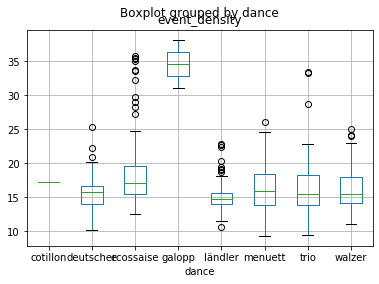

In [37]:
files['event_density'] = event_density
files.boxplot(column = 'event_density', by = 'dance');

## interval statistics for top pseudo-voice

The unfolding of the melodic line represents an highly salient feature of the music, especially in the context of popular dances. In order to stand out from the harmonic texture and be recognisable, the melody is usually formed by the topmost notes played by the right hand of the pianist. The distribution of the intervals separating consecutive notes should reflect typical features such as the prevalence of stepwise motion.

In [38]:
top_pseudovoice = pd.DataFrame(note_list[(note_list.staff == 1) & (note_list.voice == 1)].groupby(['id', 'mc', 'onset']).midi.max())

top_pseudovoice['following_midi'] = top_pseudovoice.groupby('id').midi.shift(-1)

top_pseudovoice = pd.DataFrame(top_pseudovoice.midi - top_pseudovoice.following_midi).apply(abs)

top_pseudovoice.iplot('hist', xTitle = 'midi interval' ,title = 'Distribution of intervals in top-most pseudovoice')

### distribution by dance type

In [39]:
top_pseudovoice.reset_index(level = [1,2], inplace = True)

top_pseudovoice.index = top_pseudovoice.index.map(lambda x: files.loc[x].dance)

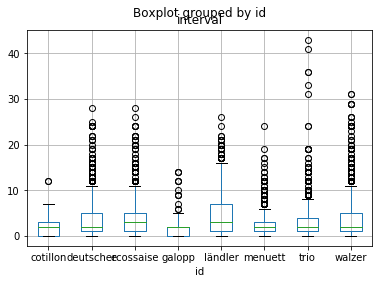

In [40]:
top_pseudovoice.rename(columns = {0: 'interval'}, inplace = True)
top_pseudovoice.boxplot(column = 'interval', by = 'id');

# roadmap for the project



## repeating pattern detection with autocorrelation (sébastien)

Plan: Autocorrelation within every piece:

* from the smallest window size to the biggest
* try different representations (rhythmical, pitch-related, textural) of every window and different distance measures

From this exploration, see which are the most promising results for further in-depth analysis.

Hypotheses:
* autocorrelation of rhythms (=very abstract representation), we expect accurate detection of repeated patterns of any length (e.g. of length 1 or 2 measures, or 8-measure-sections)
    * this will allow for formal analysis, i.e. deciding with a piece has form AABB, ABA etc.
    * it will give us reasonable segmentations of every piece by seeing, which rhythmic patterns repeat several times
* departing from the detected segmentations we can expect that the same rhythmic patterns are repeated using differnt pitches; autocorrelation might be a way to compute the harmonic and diastematic relationships

## harmony inference (johannes h.) and detection of musical schemata

This part will be using results from Johannes H's PhD project to come up with an automatic segmentation and labelling of harmonies. The point of departure is a distribution of notes  for every possible chord label, as it was avaraged over the occurrence of this chord label in several different corpora. Using an automated analysis approach with incremental windows, the windows' note distribution will be matched to the most likely label using Bayesian statistics. A short literature research should reveal existing matching algorithms, otherwise one has to be developed.

## supervised dance classification (gabriele, johannes r.)

The different types of Schubert dances have been composed for different purposes, target audiences, dances and contexts. This is reflected in their perceived musical character. In this part of the project we want to extract features from the MIDI-data that indicate these changes. This requires fusioning data analysis and musicological background information. The classification therefore mainly consists of two parts:
1. Scan of musicological literature for existing hypothesis that might hint at structural differences in the composition.
2. Supervised classification based on basic statistics, outcomes of the other project's strands and features computed from pattern detection and other metrics derived from the musicological and historical context.

The exact classification method will be dependent on the amount of features that we gather. A random forest model, ranking the features by their relevance, might help us to identify the most important criteria. Due to the sheer amount of dances, it is difficult for a human without extensive training to oversee the relevant differences. With this larger scale analysis we hope to extract some of the distinguishing factors.

# Internal: How plotting works

As you have seen, it is enough to put `.iplot()` behind your dataframe to plot it. First argument is `kind=`.

    transposed_distribution[['count_n', 'duration_n']]\
    .iplot('bar', xTitle='Tonal Pitch Class', yTitle='Normalized note counts & durations')
(This is the only page you need for Cufflinks documentation including examples: https://plot.ly/python/v3/ipython-notebooks/cufflinks/)

If you want to store the file to disk in a format of your choice, you can use my wrapper function `plot`, where `args` are the arguments used for `.iplot()` above:

    plot(df, filename, args)
So, in order to create the same plot as above while storing it as `test.pdf`, you can do:

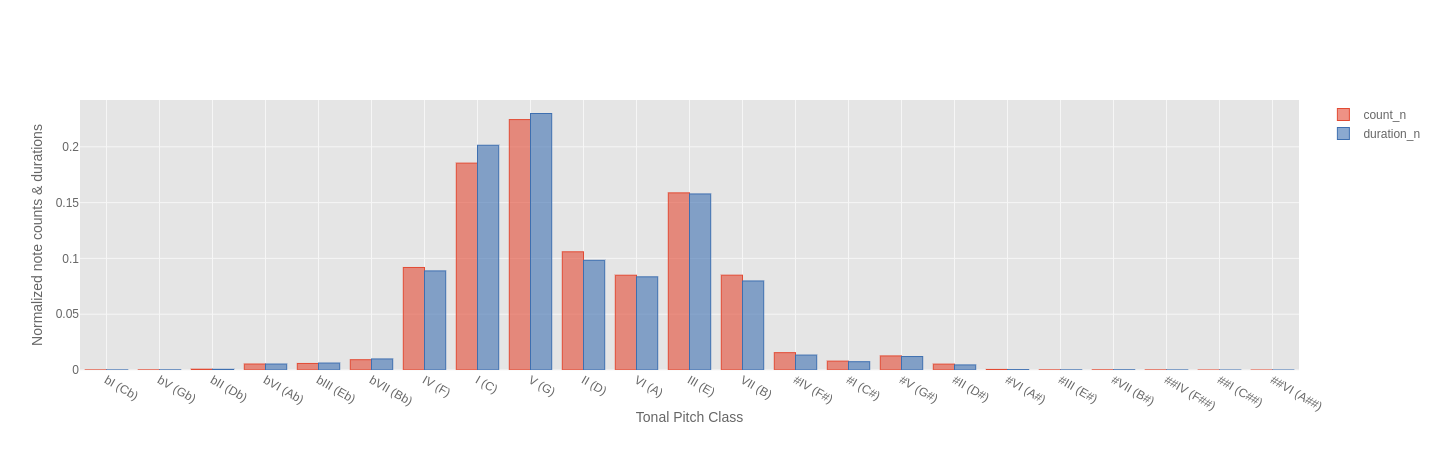

In [25]:
plot(transposed_distribution[['count_n', 'duration_n']], 'test.pdf', 'bar', xTitle='Tonal Pitch Class', yTitle='Normalized note counts & durations')

**Or, if you want to have the same code in a more readable form:**

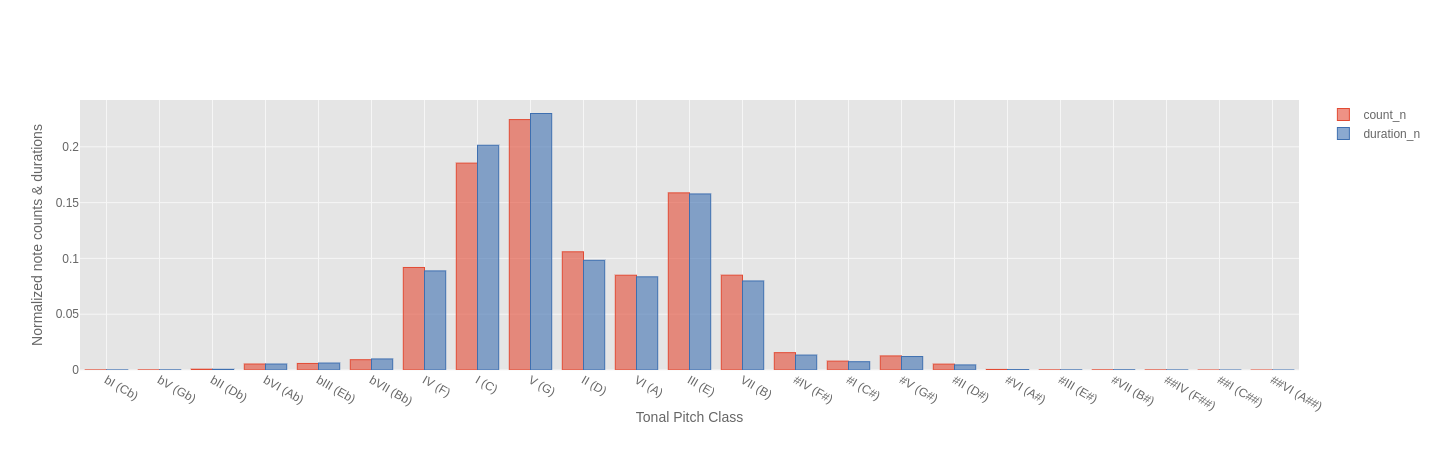

In [26]:
df = transposed_distribution[['count_n', 'duration_n']]
kwargs = {'kind': 'bar', 
          'xTitle': 'Tonal Pitch Class', 
          'yTitle':'Normalized note counts & durations'}
plot(df, 'test.pdf', **kwargs)